# Hasnah Said<br>A1: Data Curation<br>October 6, 2021

### Step 1: Data acquisition

In [1]:
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

First, I'll set up the json parameters for the API call to pagecount and pageview API

In [2]:

headers = {'User-Agent': 'https://github.com/HasnahSaid',
           'From': 'hasna024@uw.edu'}

pagecounts_access_types = ['mobile-site', 'desktop-site']
endpoint_pagecounts = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
params_pagecounts = {"project" : "en.wikipedia.org",
                 "access-site" : "", # Access types: mobile-site, desktop-site
                 "granularity" : "monthly",
                 "start" : "2008010100",
                 "end" : "2017010100"}
    
pageviews_access_types = ['mobile-app', 'mobile-web', 'desktop']   
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'
params_pageviews = {"project" : "en.wikipedia.org",
                            "access" : "", # Access types: mobile-app, mobile-web,desktop
                            "agent" : "user",
                            "granularity" : "monthly",
                            "start" : "2016010100",
                            "end" : '2021100100'}


In [3]:
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

The next two cells will iterate over the five different access types, make an API call to retrieve those records, then finally write them out as JSON file

In [4]:
# Get Pagecounts Data
pagecounts_fname = 'pagecounts_{}_200801_201701.json'
for at in pagecounts_access_types:
    params_pagecounts["access-site"] = at
    res = api_call(endpoint_pagecounts, params_pagecounts)
    with open(pagecounts_fname.format(at), 'w') as fout:
        json.dump(res, fout)


In [5]:
# Get Pageviews Data
pageviews_fname = 'pageviews_{}_201601_202110.json'
for at in pageviews_access_types:
    params_pageviews["access"] = at
    res = api_call(endpoint_pageviews, params_pageviews)
    with open(pageviews_fname.format(at),'w') as fout: 
        json.dump(res, fout)

### Step 2: Data processing

You will need to perform a series of processing steps on these data files in order to prepare them for analysis. These steps must be followed carefully in order to prepare the data for analysis. At the end of this step, you will have a single CSV-formatted data file that can be used in your analysis (Step 3) with no significant additional processing.

* For data collected from the Pageviews API, combine the monthly values for mobile-app and mobile-web to create a total mobile traffic count for each month.

* For all data, separate the value of timestamp into four-digit year (YYYY) and two-digit month (MM) and discard values for day and hour (DDHH).

Combine all data into a single CSV file with the following headers:
1. year
2. month
3. pagecount_all_views
4. pagecount_desktop_views
5. pagecount_mobile_views
6. pageview_all_views
7. pageview_desktop_views
8. pageview_mobile_views


The steps I followed in processing the views JSON files are: 
    1. Read in the JSON files, normalize them and drop columns that are not needed
    2. Merge pageview mobile app and mobile web by adding those values into one column
    3. Merge the rest of the columns to the combined dataframe, sum all the views, and rename the columns
    4. Split the timestamp column into month and year columns, then drop unneeded columns
    5. Convert null cells to 0
    6. Reorder the columns 

In [6]:
# Read files as pandas DataFrame

#Pagecounts
pc_desktop = pd.json_normalize(pd.read_json('pagecounts_desktop-site_200801_201701.json')['items'])[['timestamp', 'count']]
pc_mobile = pd.json_normalize(pd.read_json('pagecounts_mobile-site_200801_201701.json')['items'])[['timestamp', 'count']]

#Pageviews
pv_desktop = pd.json_normalize(pd.read_json('pageviews_desktop_201601_202110.json')['items'])[['timestamp', 'views']]
pv_mobile_app = pd.json_normalize(pd.read_json('pageviews_mobile-app_201601_202110.json')['items'])[['timestamp', 'views']]
pv_mobile_web = pd.json_normalize(pd.read_json('pageviews_mobile-web_201601_202110.json')['items'])[['timestamp', 'views']]


In [7]:
# Merge mobile views for Pageviews API
pv_mobile = pd.merge(pv_mobile_app, pv_mobile_web, on='timestamp')
pv_mobile['pageview_mobile_views'] = pv_mobile_app['views'] + pv_mobile_web['views']

In [8]:
# Merge in the rest of the columns and rename them
df_combined = pd.merge(pc_desktop, pc_mobile, on='timestamp', how='outer')
df_combined = pd.merge(df_combined, pv_desktop, on='timestamp', how='outer')
df_combined = pd.merge(df_combined, pv_mobile, on='timestamp', how='outer')
df_combined = df_combined.rename(columns={'count_x': 'pagecount_desktop_views', 'count_y':'pagecount_mobile_views', 'views':'pageview_desktop_views'})
df_combined['pagecount_all_views'] = df_combined['pagecount_mobile_views'] + df_combined['pagecount_desktop_views']
df_combined['pageview_all_views'] = df_combined['pageview_desktop_views'] + df_combined['pageview_mobile_views']

In [9]:
# Separate the timestamp into month and year
df_combined['month'] = df_combined['timestamp'].str[4:6]
df_combined['year'] = df_combined['timestamp'].str[:4]
# Delete extra columns
del(df_combined['timestamp'])
del(df_combined['views_x'])
del(df_combined['views_y'])

For months with 0 pageviews for a given access method (e.g. desktop-site, mobile-app), that value for that (column, month) should be listed as 0. So for example all values of pagecount_mobile_views for months before October 2014 should be 0, because mobile traffic data is not available before that month.
The final data file should be named:<br>
en-wikipedia_traffic_200712-202108.csv


In [10]:
df_combined = df_combined.fillna(0)

In [11]:
# Reorder columns in final combined dataframe
df_combined = df_combined[["year", "month", 
                           "pagecount_all_views", 
                           "pagecount_desktop_views", 
                           "pagecount_mobile_views", 
                           "pageview_all_views", 
                           "pageview_desktop_views", 
                           "pageview_mobile_views"]]

In [12]:
df_combined.head()

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2008,01,0.0,4.930903e+09,0.0,0.0,0.0,0.0
1,2008,02,0.0,4.818394e+09,0.0,0.0,0.0,0.0
2,2008,03,0.0,4.955406e+09,0.0,0.0,0.0,0.0
3,2008,04,0.0,5.159162e+09,0.0,0.0,0.0,0.0
4,2008,05,0.0,5.584691e+09,0.0,0.0,0.0,0.0


In [17]:
df_combined.columns

Index(['year', 'month', 'pagecount_all_views', 'pagecount_desktop_views',
       'pagecount_mobile_views', 'pageview_all_views',
       'pageview_desktop_views', 'pageview_mobile_views'],
      dtype='object')

In [13]:
df_combined.to_csv('en-wikipedia_traffic_200712-202108.csv', index=False)

### Step 3: Analysis

For this assignment, the "analysis" will be fairly straightforward: you will visualize the dataset you have created as a time series graph.<br>
Your visualization will track three traffic metrics: mobile traffic, desktop traffic, and all traffic (mobile + desktop).<br>
In order to complete the analysis correctly and receive full credit, your graph will need to be the right scale to view the data; all units, axes, and values should be clearly labeled. Your graph should possess a legend and a title. You must generate a .png or .jpeg formatted image of your final graph.<br>
Please graph the data in Python or R, in your notebook, rather than using an external application to facilitate reproducibility.


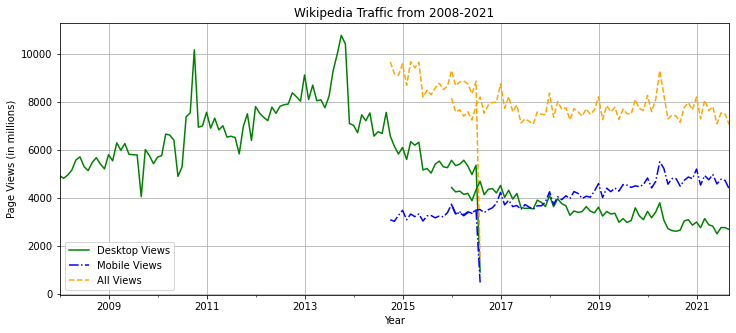

In [14]:
# Load Data from csv file to a dataframe
df = pd.read_csv('en-wikipedia_traffic_200712-202108.csv')
df.replace(0, np.nan, inplace=True)

# Convert month, year to one date column
df['date'] = pd.to_datetime(df[['year','month']].assign(day=1))
del(df['month'])
del(df['year'])

# Convert to 1000000
view_count_columns = ['pagecount_all_views', 'pagecount_desktop_views', 'pagecount_mobile_views',
                      'pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views']
for column_name in view_count_columns:
    df[column_name] = df[column_name].div(1000000).round(2)
    
# Plot pagecount views
df.set_index(df['date'])['pagecount_desktop_views'].plot(color='green', linestyle='-', figsize=(12,5))
df.set_index(df['date'])['pagecount_mobile_views'].plot(color='blue', linestyle='-.')
df.set_index(df['date'])['pagecount_all_views'].plot(color='orange', linestyle='--')
# Plot pageview views
df.set_index(df['date'])['pageview_desktop_views'].plot(color='green', linestyle='-')
df.set_index(df['date'])['pageview_mobile_views'].plot(color='blue', linestyle='-.')
df.set_index(df['date'])['pageview_all_views'].plot(color='orange', linestyle='--')

# Label axis, add title, add grids, add legends
plt.xlabel('Year')
plt.ylabel('Page Views (in millions)')
plt.grid()
plt.title('Wikipedia Traffic from 2008-2021')
plt.legend(('Desktop Views', 'Mobile Views', 'All Views'), loc='lower left')


# Save plot as .png
plt.savefig('wiki_traffic_2008_2021.png')